In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow_datasets as tfds

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

from rec.models.resnet_vae import BidirectionalResNetVAE
from rec.models.custom_modules import ReparameterizedConv2D, ReparameterizedConv2DTranspose, GDN
from rec.models.pixel_cnn import PixelCNNResidualBlock

from rec.coding.coder import GaussianCoder
from rec.coding.samplers import ImportanceSampler

from rec.models.large_resnet_vae import LargeResNetVAE

from rec.io.entropy_coding import ArithmeticCoder

In [2]:
# Taken from https://github.com/tensorflow/tensorflow/issues/31135#issuecomment-516526113
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [12]:
x = tf.random.uniform((1, 2, 3, 4), dtype=tf.float32)
y = GDN(inverse=False)(x)
print(x.shape, y.shape)
print(tf.reduce_max(tf.abs(y - x / tf.sqrt(1 + .1 * (x ** 2)))))

x = tf.random.uniform((1, 2, 3, 4), dtype=tf.float32)
y = GDN(inverse=True)(x)
print(x.shape, y.shape)
print(tf.reduce_max(tf.abs(y - x * tf.sqrt(1 + .1 * (x ** 2)))))

(1, 2, 3, 4) (1, 2, 3, 4)
tf.Tensor(2.3841858e-07, shape=(), dtype=float32)
(1, 2, 3, 4) (1, 2, 3, 4)
tf.Tensor(0.0, shape=(), dtype=float32)


In [16]:
block_indices = np.load("../block_indices.npy", allow_pickle=True)

block_sizes = list(map(len, block_indices))
num_aux_vars = [list(map(len, block)) for block in block_indices]

block0 = np.concatenate(block_indices[0] + [[-1]], axis=0) + 1
block1 = np.concatenate(block_indices[1] + [[-1]], axis=0) + 1

In [18]:
uniques, counts = np.unique(block0, return_counts=True)
counts

array([  1,  70,  98,  95, 102, 104,  91,  93,  96,  97,  88,  95, 106,
        94,  80,  90,  78, 110,  80,  80,  99])

In [20]:
ac = ArithmeticCoder(counts, precision=32)

100%|██████████| 21/21 [00:00<00:00, 19612.64it/s]

Building tree
Depth of symbol tree: 6


In [24]:
code = ac.encode(block0)
decoded = ac.decode_fast(code)

100%|██████████| 1847/1847 [00:00<00:00, 167149.53it/s]


In [29]:
np.array(decoded) == block0

array([ True,  True,  True, ...,  True,  True,  True])

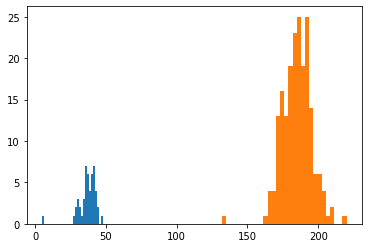

In [22]:
num_aux_vars = list(map(len, block_indices[0]))

plt.hist(num_aux_vars, bins=30)

num_aux_vars = list(map(len, block_indices[1]))

plt.hist(num_aux_vars, bins=30)
plt.show()

In [3]:
!ls ../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/

checkpoint		       ckpt-2127.index
ckpt-2126.data-00000-of-00002  ckpt-2128.data-00000-of-00002
ckpt-2126.data-00001-of-00002  ckpt-2128.data-00001-of-00002
ckpt-2126.index		       ckpt-2128.index
ckpt-2127.data-00000-of-00002  logs
ckpt-2127.data-00001-of-00002


In [4]:
model_save_dir = "../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/"

In [5]:
model = BidirectionalResNetVAE(use_iaf=False,
                               num_res_blocks=24,
                               deterministic_filters=160,
                               stochastic_filters=32)

model(tf.zeros((1, 32, 32, 3)))

# -------------------------------------------------------------------------
# Create Checkpoints
# -------------------------------------------------------------------------
ckpt = tf.train.Checkpoint(model=model)

manager = tf.train.CheckpointManager(ckpt, model_save_dir, max_to_keep=3)

# Restore previous session
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("Initializing model from scratch.")

Restored model from ../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/ckpt-2128


In [10]:
model.swap_in_ema_variables()

In [6]:
ds = tfds.load("downsampled_imagenet/32x32", data_dir="/scratch/gf332/datasets/imagenet32")["validation"]
ds = ds.map(lambda x: tf.clip_by_value((tf.cast(x["image"], tf.float32) + 0.5) / 256., 0.0, 1.0) - 0.5)

In [7]:
max_test_images = 10000
max_batch_size = 100
test_images = 300

batched_ds = ds.take(test_images).batch(max_batch_size)

In [11]:
# Calculate average (negative) ELBO on test dataset
neg_elbos = []

for img in tqdm(batched_ds.take(test_images), total=test_images // max_batch_size):
    res = model(img)
    
    neg_elbo = -model.log_likelihood + model.kl_divergence(empirical=False, minimum_kl=0.)

    neg_elbos.append(neg_elbo)

In [9]:
bpp = tf.reduce_mean(neg_elbos) / (32 * 32 * np.log(2))
bppc = bpp / 3

print(bpp, bppc)

tf.Tensor(13.757815, shape=(), dtype=float32) tf.Tensor(4.5859385, shape=(), dtype=float32)


In [12]:
bpp = tf.reduce_mean(neg_elbos) / (32 * 32 * np.log(2))
bppc = bpp / 3

print(bpp, bppc)

tf.Tensor(13.529109, shape=(), dtype=float32) tf.Tensor(4.509703, shape=(), dtype=float32)


In [6]:
def get_t_p_gauss(filename, dims=1000):
    t_mean = np.tile(np.load(filename + 'post_loc.npy')[0], 1 + dims // 50)[:dims]
    t_scale = np.tile(np.load(filename + 'post_scale.npy')[0], 1 + dims // 50)[:dims]
    p_mean = np.tile(np.load(filename + 'prior_loc.npy'), 1 + dims // 50)[:dims]
    p_scale = np.tile(np.load(filename + 'prior_scale.npy'), 1 + dims // 50)[:dims]

    ndims = p_mean.shape[0]
    print('Dimensions: {}'.format(ndims))
    p = tfp.distributions.Normal(loc=p_mean, scale=p_scale)
    t = tfp.distributions.Normal(loc=t_mean, scale=t_scale)
    print('KL divergence: {}'.format(tf.reduce_sum(tfp.distributions.kl_divergence(t, p))))
    return t, p

mnist_path = '/scratch/gf332/CWOQ/relative-entropy-coding/experimental_data/data_distributions/mnist/beta_1_latents_50/test/img_{}/'

t_list = []
p_list = []
for i in range(2):
    t, p = get_t_p_gauss(filename=mnist_path.format(i), dims=500)
    t_list.append(t)
    p_list.append(p)

target_kl = 10.

Dimensions: 500
KL divergence: 283.4400634765625
Dimensions: 500
KL divergence: 291.41802978515625


In [12]:
from rec.coding.rejection_sampling import get_aux_distribution, preprocessing_auxiliary_ratios, get_conditionals
from rec.coding.coder import get_auxiliary_coder, get_auxiliary_target, get_conditional_coder, get_conditional_target

In [31]:
aux_var = 0.1

t1, p1 = get_aux_distribution(t_list[0],
                     p_list[0],
                     aux_var)

t2 = get_auxiliary_target(t_list[0],
                          p_list[0],
                          aux_var)
p2 = get_auxiliary_coder(p_list[0],
                         aux_var)

print("aux")
print(f"t loc diff: {tf.reduce_max(tf.abs(t1.loc - t2.loc))}")
print(f"t scale diff: {tf.reduce_max(tf.abs(t1.scale - t2.scale))}")

print(f"p loc diff: {tf.reduce_max(tf.abs(p1.loc - p2.loc))}")
print(f"p scale diff: {tf.reduce_max(tf.abs(p1.scale - p2.scale))}")

aux_samp = t2.sample()

tc1, pc1 = get_conditionals(t_list[0],
                            p_list[0],
                            aux_var,
                            aux_samp)

tc2 = get_conditional_target(t_list[0],
                            p_list[0],
                            aux_var,
                            aux_samp)

pc2 = get_conditional_coder(p_list[0],
                            aux_var,
                            aux_samp)

print("\n cond")
print(f"t loc diff: {tf.reduce_max(tf.abs(tc1.loc - tc2.loc))}")
print(f"t scale diff: {tf.reduce_max(tf.abs(tc1.scale - tc2.scale))}")

print(f"p loc diff: {tf.reduce_max(tf.abs(pc1.loc - pc2.loc))}")
print(f"p scale diff: {tf.reduce_max(tf.abs(pc1.scale - pc2.scale))}")

aux
t loc diff: 0.0
t scale diff: 2.9802322387695312e-08
p loc diff: 0.0
p scale diff: 0.0

 cond
t loc diff: 0.0
t scale diff: 0.0
p loc diff: 0.0
p scale diff: 0.0


In [ ]:
# aux_ratios = np.array([0.68339353, 0.54674925, 0.46513237, 0.4246385,  0.39013079, 0.37761325])
aux_ratios = preprocessing_auxiliary_ratios(t_list, p_list, target_kl)